# (12104) Chesley orbit determination test

#### Let's start by importing the necessary libraries

In [1]:
from grss import fit
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)

#### We'll then retrieve the cometary state of the asteroid (from JPL SBDB) plus any nongravitational accelerations acting on it.

In [2]:
body_id = '12104'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
de_kernel = 440

#### Next, we'll retrieve the observations from different sources (MPC, JPL, Gaia Data Releases) and prepare them for the orbit determination process.

In [3]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_lowres = True
deweight = True
eliminate = False
num_obs_per_night = 4
verbose = True
obs_df = fit.get_optical_obs(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias_lowres, deweight, eliminate, num_obs_per_night, verbose)
obs_df = fit.add_radar_obs(obs_df, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_df = fit.add_gaia_obs(obs_df, t_min_tdb, t_max_tdb, gaia_dr, verbose)

Read in 5620 observations from the MPC.
	Filtered to 5620 observations that satisfy the time range and accepted observatory constraints.
Applying Eggl et al. (2020) debiasing scheme to the observations.
	Unknown star catalog: UNK
	No debiasing needed for 4309 observations.
	Debiased 1289 observations.
	No bias information for 22 observations.
Applying Vereš et al. (2017) weighting scheme to the observations.
	Using 3314 CCD observations with station-specific weight rules.
Applying sqrt(N/4) deweighting scheme.
	Deweighted 2676 observations.
Read in 459 Gaia observations from gaiafpr
	Filtered to 459 observations that satisfy the time range constraints.


#### All we need to do now is initialize the OD simulation and run the filter.

In [4]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, obs_df, init_cov, n_iter_max=n_iter_max, de_kernel=de_kernel, nongrav_info=nongrav_info)

In [5]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.742			 0.481			 2815.965			 0.232
2			 0.742			 0.481			 2815.951			 0.232
Converged without rejecting outliers. Starting outlier rejection now...
3			 0.709			 0.444			 2399.703			 0.198
Converged after rejecting outliers. Rejected 28 out of 6079 optical observations.


#### Let's print some summary statistics and plot some results.

In [6]:
fit_sim.print_summary()

Summary of the orbit fit calculations after postfit pass:
RMS unweighted: 0.7088401675576925
RMS weighted: 0.4442707204018344
chi-squared: 2399.7031588113846
reduced chi-squared: 0.1983881579705179
square root of reduced chi-squared: 0.4454078557575269
--------------------------------------------------------------
Solution Time: MJD 58122.000 TDB = 2018-01-04 00:00:00.000 TDB
Solution Observation Arc: 17933.48 days (49.10 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value			Uncertainty			Change				Change (sigma)
e			2.44896320089e-02		7.35000612766e-10		2.44896319517e-02		7.10109529370e-10		-5.72301581125e-11		-0.081
q			2.93644529683e+00		3.42020021224e-09		2.93644529713e+00		3.31177779548e-09		+2.95431679120e-10		+0.089
tp			5.87280803654e+04		6.74589596505e-06		5.87280803653e+04		6.53447548768e-06		-1.71377905644e-07		-0.026
om			7.80640070842e+01		1.25609841342e-07		7.80640070803e+01		1.18657423896e-07		

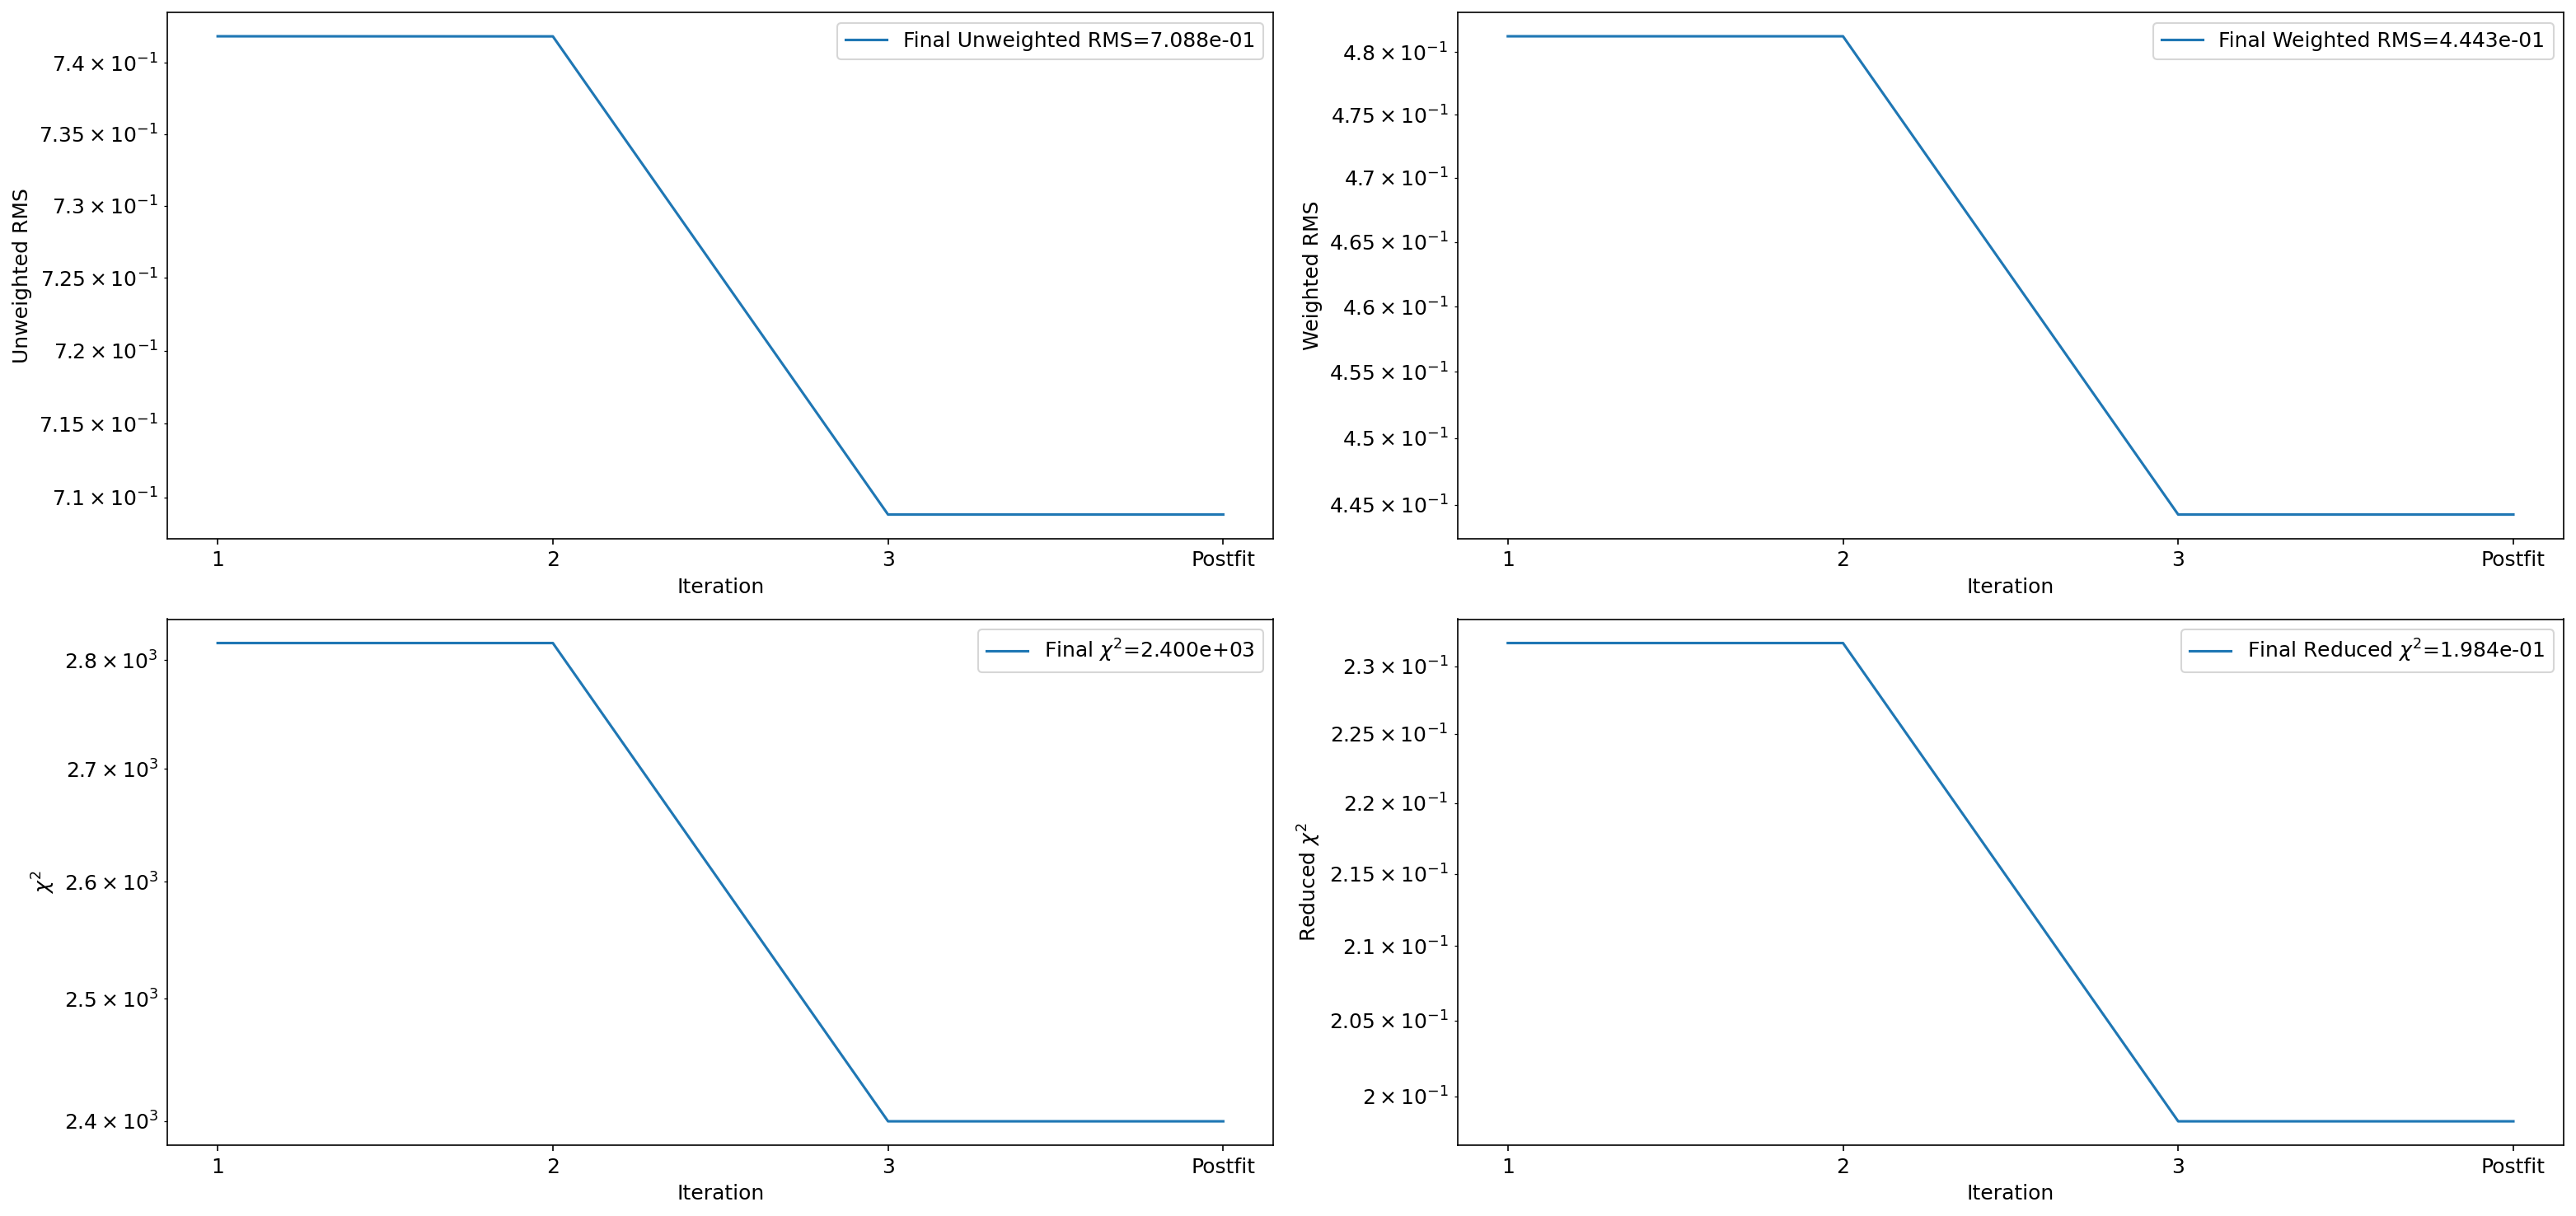

In [7]:
fit_sim.plot_summary(auto_close=True)

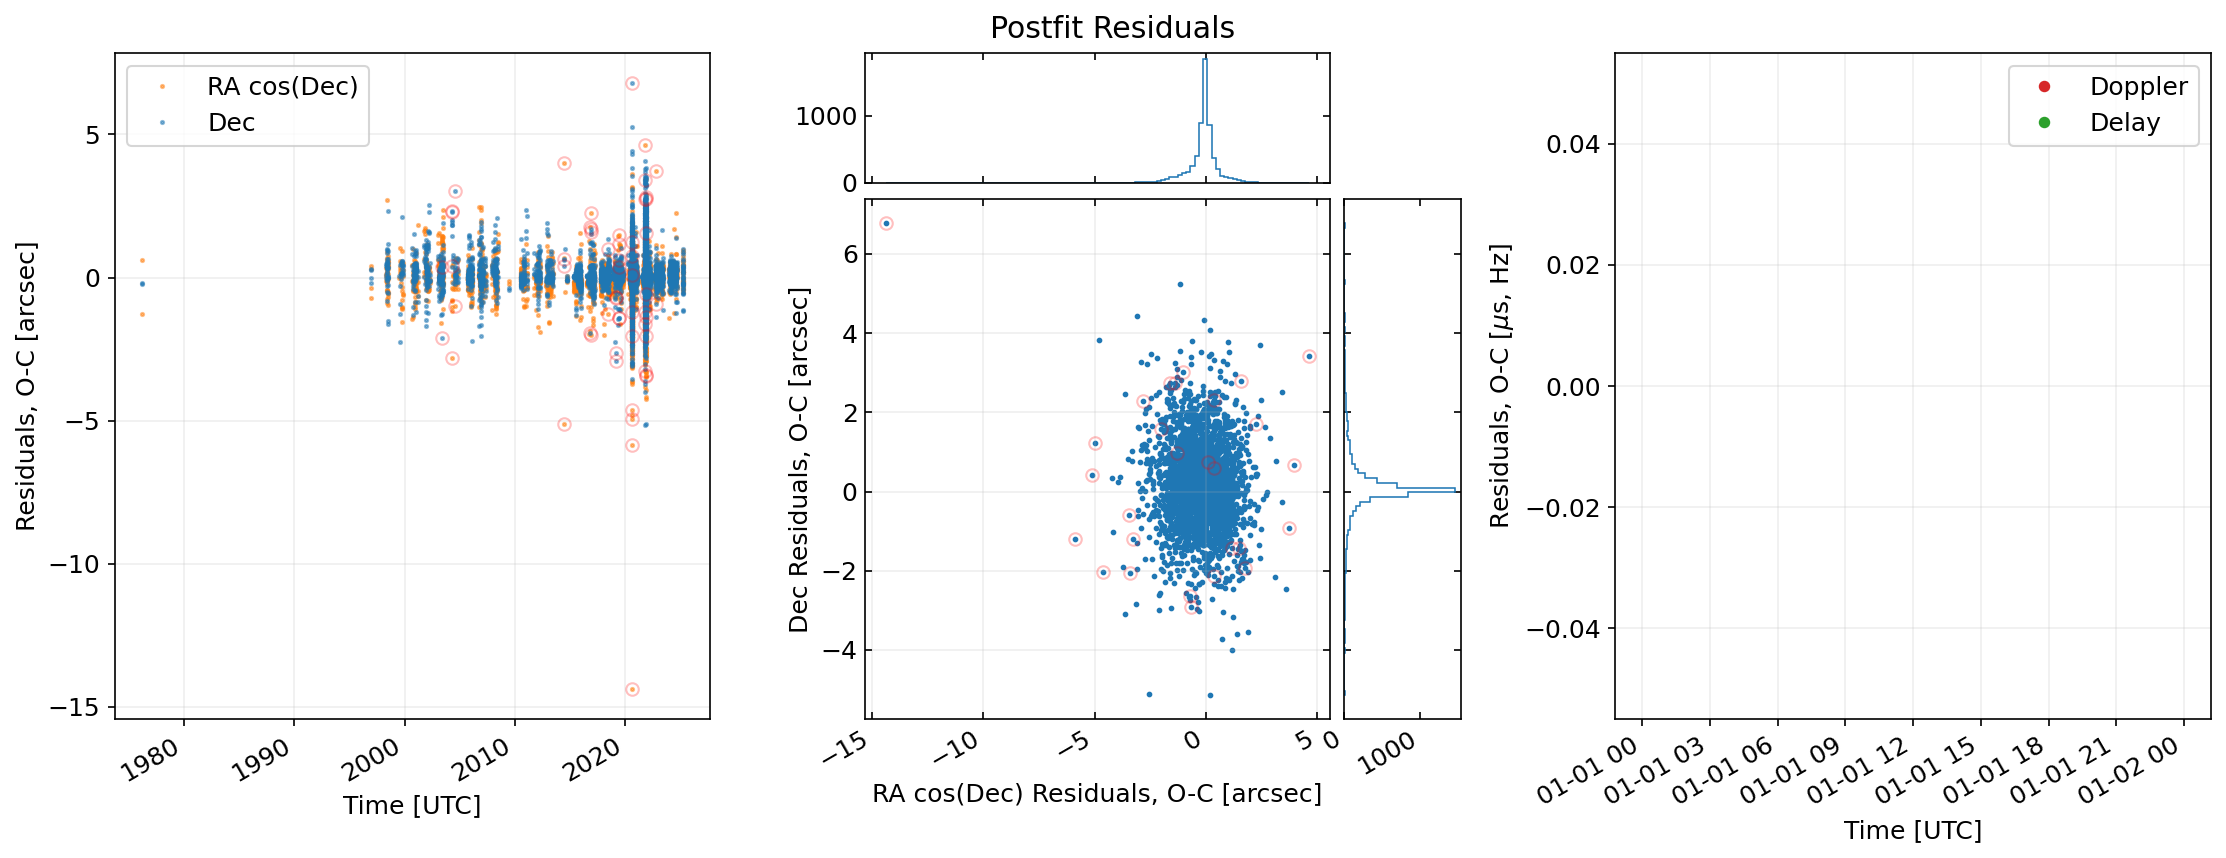

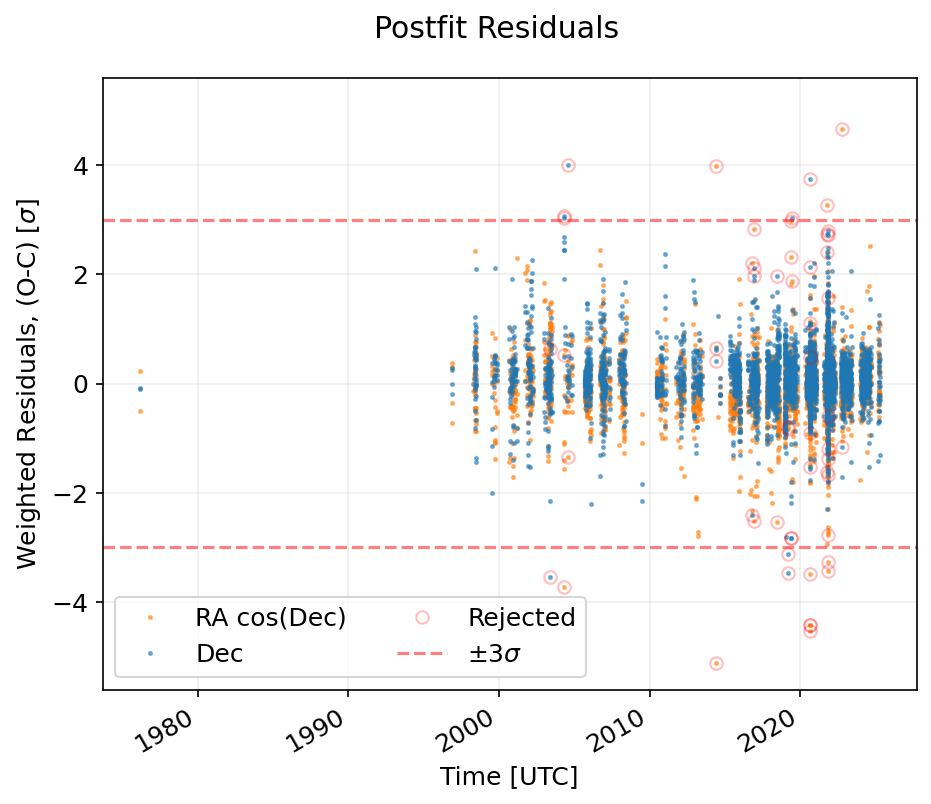

In [8]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [9]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 0.11
Mahalonobis distance between GRSS and JPL solution: 0.12
Bhattacharya distance between JPL and GRSS solution: 0.0028
Bhattacharya coefficient between JPL and GRSS solution: 0.9972


#### Finally, we'll make sure the GRSS solution is statistically consistent with the JPL SBDB solution

In [10]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90